# Neural Network Sample

## Building a neural network

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from statistics import mean
from typing import Dict, List, Tuple

np.random.seed(7191)

class Neural:

    def __init__(self, layers: List[int], epochs: int,
                 learning_rate: float = 0.001, batch_size: int=32,
                 validation_split: float = 0.2, verbose: int=1):
        self._layer_structure: List[int] = layers
        self._batch_size: int = batch_size
        self._epochs: int = epochs
        self._learning_rate: float = learning_rate
        self._validation_split: float = validation_split
        self._verbose: int = verbose
        self._losses: Dict[str, float] = {"train": [], "validation": []}
        self._is_fit: bool = False
        self.__layers = None

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        # validation split
        X, X_val, y, y_val = train_test_split(X, y, test_size=self._validation_split, random_state=42)
        # initialization of layers
        self.__layers = self.__init_layers()
        for epoch in range(self._epochs):
            epoch_losses = []
            for i in range(1, len(self.__layers)):
                # forward pass
                x_batch = X[i:(i+self._batch_size)]
                y_batch = y[i:(i+self._batch_size)]
                pred, hidden = self.__forward(x_batch)
                # calculate loss
                loss = self.__calculate_loss(y_batch, pred)
                epoch_losses.append(np.mean(loss ** 2))
                #backward
                self.__backward(hidden, loss)
            valid_preds, _ = self.__forward(X_val)
            train_loss = mean(epoch_losses)
            valid_loss = np.mean(self.__calculate_mse(valid_preds,y_val))
            self._losses["train"].append(train_loss)
            self._losses["validation"].append(valid_loss)
            if self._verbose:
                print(f"Epoch: {epoch} Train MSE: {train_loss} Valid MSE: {valid_loss}")
        self._is_fit = True
        return

    def predict(self, X: np.ndarray) -> np.ndarray:
        if self._is_fit == False:
            raise Exception("Model has not been trained yet.")
        pred, hidden = self.__forward(X)
        return pred

    def plot_learning(self) -> None:
        plt.plot(self._losses["train"],label="loss")
        plt.plot(self._losses["validation"],label="validation")
        plt.legend()

    def __init_layers(self) -> List[np.ndarray]:
        layers = []
        for i in range(1, len(self._layer_structure)):
            layers.append([
                np.random.rand(self._layer_structure[i-1], self._layer_structure[i]) / 5 - .1,
                np.ones((1,self._layer_structure[i]))
            ])
        return layers

    def __forward(self, batch: np.ndarray) -> Tuple[np.ndarray, List[np.ndarray]]:
        hidden = [batch.copy()]
        for i in range(len(self.__layers)):
            batch = np.matmul(batch, self.__layers[i][0]) + self.__layers[i][1]
            if i < len(self.__layers) - 1:
                batch = np.maximum(batch, 0) #activation function
            # Store the forward pass hidden values for use in backprop
            hidden.append(batch.copy())
        return batch, hidden

    def __calculate_loss(self,actual: np.ndarray, predicted: np.ndarray) -> np.ndarray:
        "mse"
        return predicted - actual


    def __calculate_mse(self, actual: np.ndarray, predicted: np.ndarray) -> np.ndarray:
        return (actual - predicted) ** 2

    def __backward(self, hidden: List[np.ndarray], grad: np.ndarray) -> None:
        for i in range(len(self.__layers)-1, -1, -1):
            if i != len(self.__layers) - 1:
                grad = np.multiply(grad, np.heaviside(hidden[i+1], 0))

            w_grad = hidden[i].T @ grad
            b_grad = np.mean(grad, axis=0)

            self.__layers[i][0] -= w_grad * self._learning_rate
            self.__layers[i][1] -= b_grad * self._learning_rate

            grad = grad @ self.__layers[i][0].T
        return

**Loading the dataset**

In [ ]:
df=pd.read_csv('data.csv')

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['diagnosis'] = le.fit_transform(df['diagnosis'])

df = df.drop('id',axis=1)
df =  df.drop('Unnamed: 32',axis=1)

In [ ]:
df

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,1,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,1,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,1,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,1,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


Considering 'diagnosis' as the target feature.

**Feature Engineering**

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

X = df.drop('diagnosis', axis=1)  # Features
y = df['diagnosis']  # Target variable


k_best = SelectKBest(score_func=f_classif, k=7)
X_cfs = k_best.fit_transform(X, y)


selected_indices = k_best.get_support(indices=True)


selected_features = X.columns[selected_indices]


print("Selected features using CFS:")
print(selected_features)


Selected features using CFS:
Index(['radius_mean', 'perimeter_mean', 'concave points_mean', 'radius_worst',
       'perimeter_worst', 'area_worst', 'concave points_worst'],
      dtype='object')


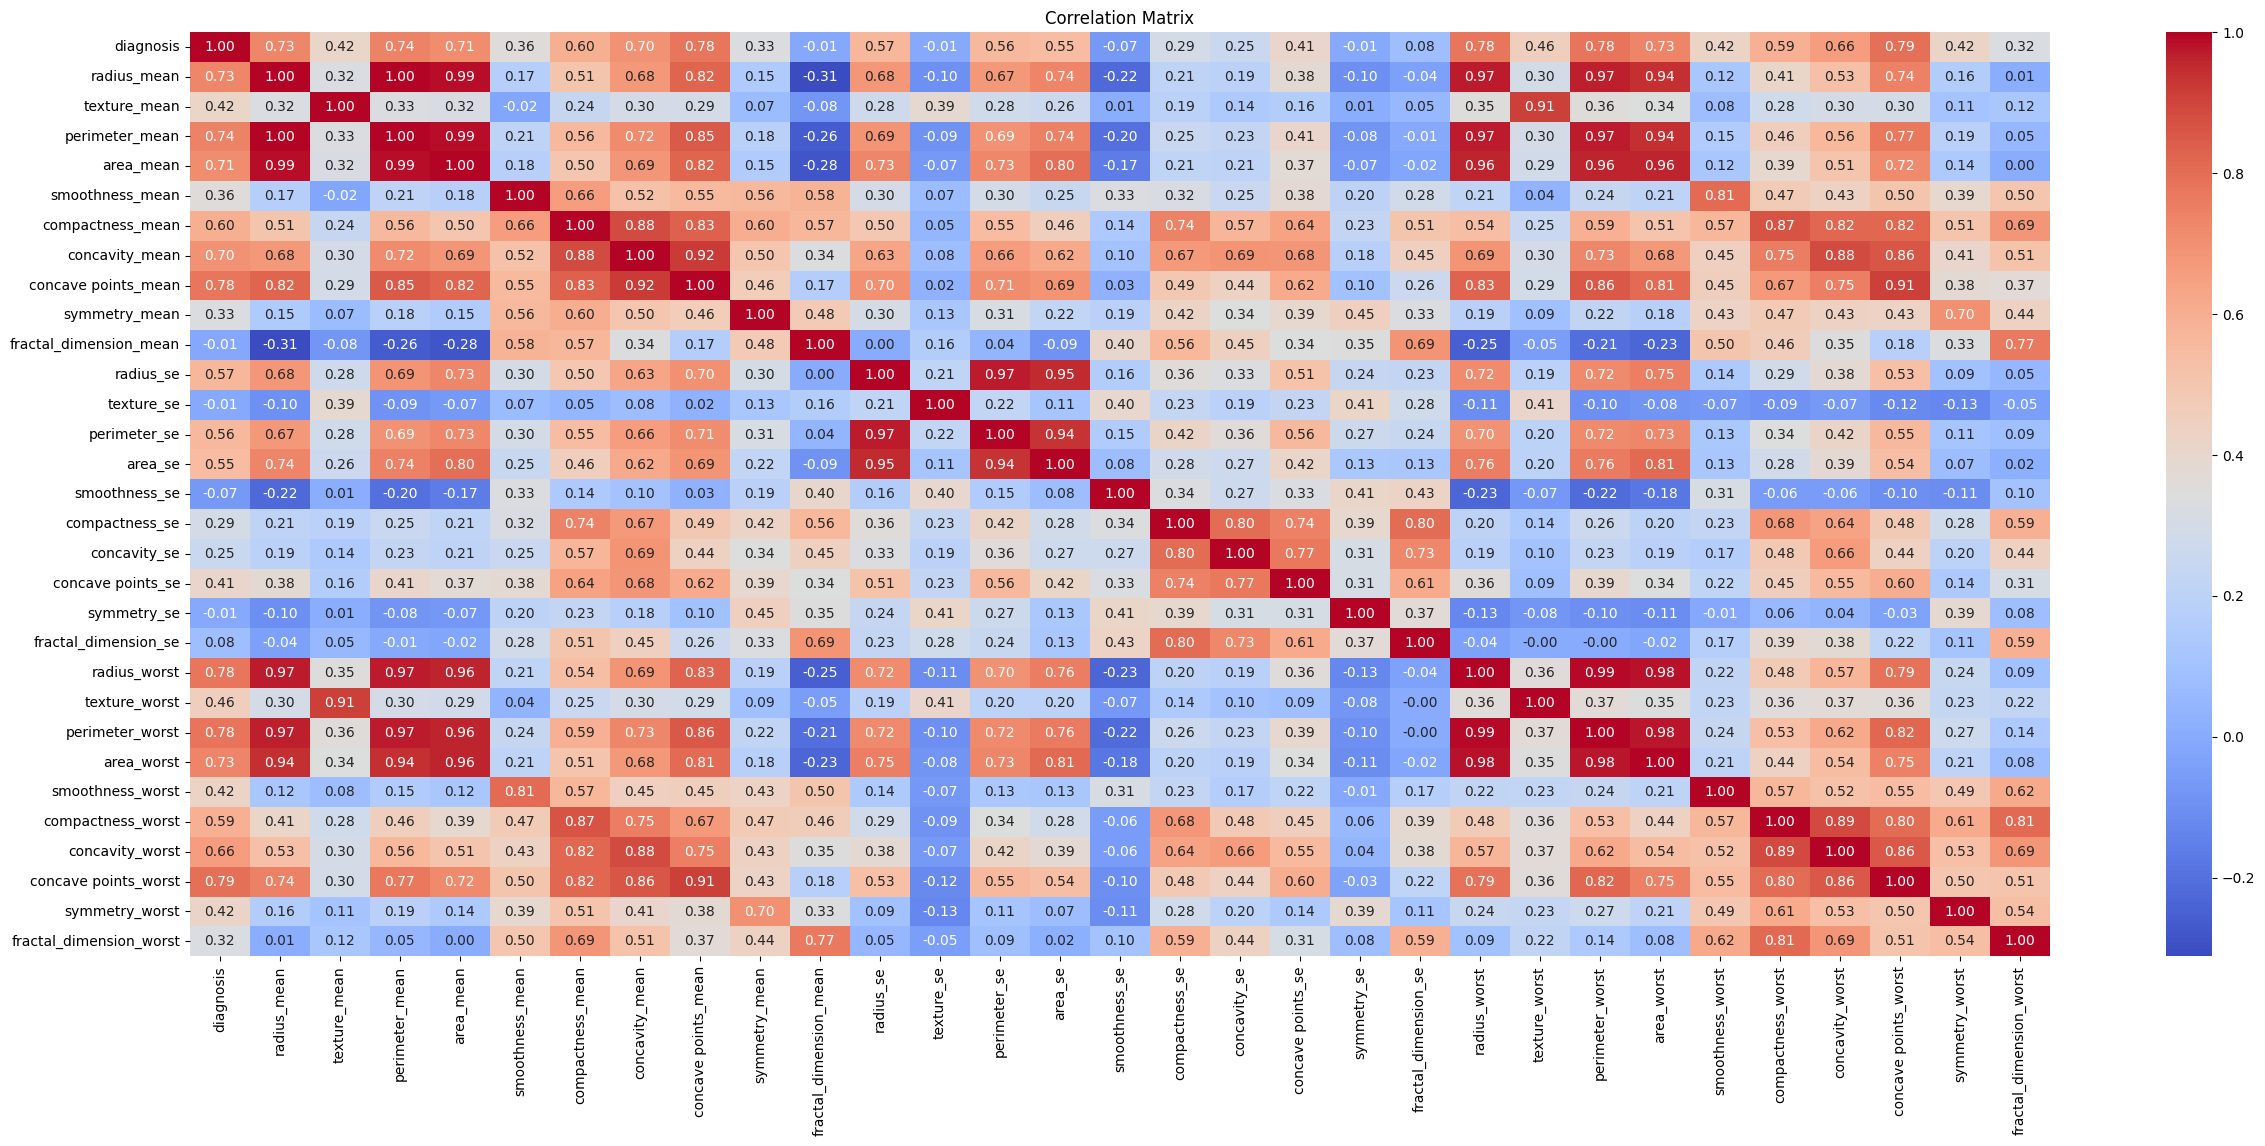

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


correlation_matrix = df.corr()


plt.figure(figsize=(30, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [ ]:
X = df[['radius_mean','perimeter_mean','area_mean','concave points_worst','perimeter_worst','radius_worst','concave points_mean']]
y = df['diagnosis']

In [ ]:
X

,radius_mean,perimeter_mean,area_mean,concave points_worst,perimeter_worst,radius_worst,concave points_mean
0,17.99,122.80,1001.0,0.2654,184.60,25.380,0.14710
1,20.57,132.90,1326.0,0.1860,158.80,24.990,0.07017
2,19.69,130.00,1203.0,0.2430,152.50,23.570,0.12790
3,11.42,77.58,386.1,0.2575,98.87,14.910,0.10520
4,20.29,135.10,1297.0,0.1625,152.20,22.540,0.10430
...,...,...,...,...,...,...,...
564,21.56,142.00,1479.0,0.2216,166.10,25.450,0.13890
565,20.13,131.20,1261.0,0.1628,155.00,23.690,0.09791
566,16.60,108.30,858.1,0.1418,126.70,18.980,0.05302
567,20.60,140.10,1265.0,0.2650,184.60,25.740,0.15200


In [ ]:
y

0      1
1      1
2      1
3      1
4      1
      ..
564    1
565    1
566    1
567    1
568    0
Name: diagnosis, Length: 569, dtype: int64

**Configuration #1**

Test error:  0.05241387827845701
Test error:  0.04972667296082125
Test error:  0.03377514368411796
Test error:  0.042160364114723695
Test error:  0.03725720472411595


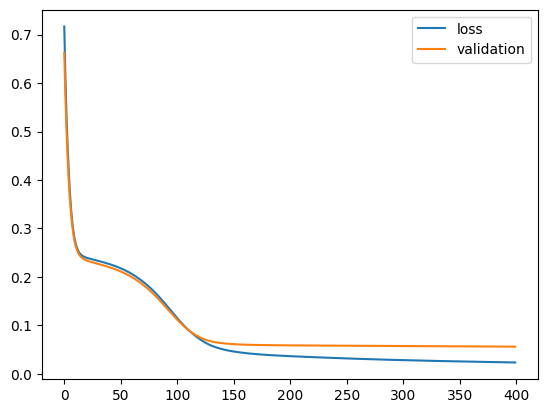

In [ ]:
from sklearn.metrics import mean_squared_error
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train = y_train.to_numpy().reshape(-1,1)
y_test = y_test.to_numpy().reshape(-1,1)

epocs = 400
learn_rate = .001
batch_size = 30
val_split = .3
verbose = 0

layer_structure = [X_train.shape[1],5,2,1]
for i in range(5):
  nn = Neural(layer_structure, epocs, learn_rate, batch_size, val_split, verbose)

  nn.fit(X_train, y_train)
  y_pred = nn.predict(X_test)
  print("Test error: ",mean_squared_error(y_test, y_pred))

nn.plot_learning()

**Configuration #2**

Test error:  0.04019593731005884
Test error:  0.03296801433364836
Test error:  0.044087103127692186
Test error:  0.035691565699121505
Test error:  0.03587402121313118


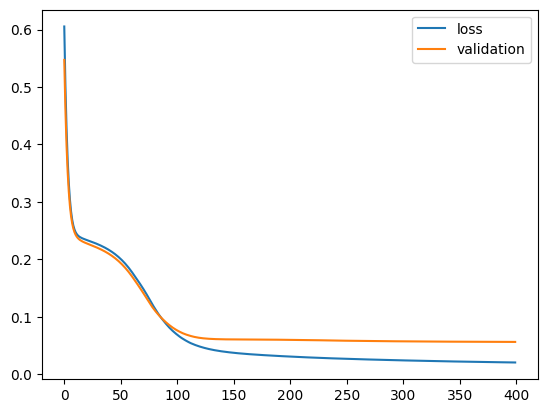

In [ ]:
from sklearn.metrics import mean_squared_error
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train = y_train.to_numpy().reshape(-1,1)
y_test = y_test.to_numpy().reshape(-1,1)

epocs = 400
learn_rate = .001
batch_size = 30
val_split = .3
verbose = 0

layer_structure = [X_train.shape[1],5,3,1]
for i in range(5):
  nn = Neural(layer_structure, epocs, learn_rate, batch_size, val_split, verbose)

  nn.fit(X_train, y_train)
  y_pred = nn.predict(X_test)
  print("Test error: ",mean_squared_error(y_test, y_pred))


nn.plot_learning()



**Configuration #3**

Test error:  0.029602831997463167
Test error:  0.027973739980587692
Test error:  0.05854786225271034
Test error:  0.030244039885252344
Test error:  0.028550235078485142


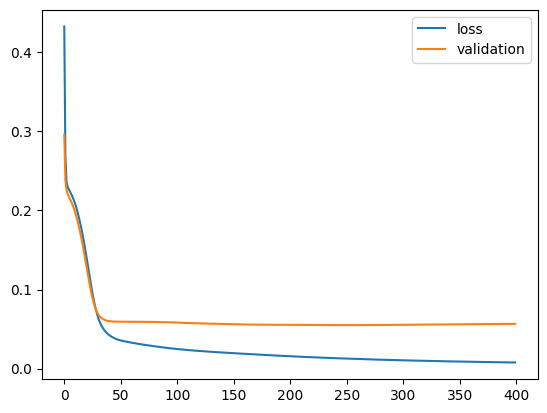

In [ ]:
from sklearn.metrics import mean_squared_error
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train = y_train.to_numpy().reshape(-1,1)
y_test = y_test.to_numpy().reshape(-1,1)

epocs = 400
learn_rate = .003
batch_size = 35
val_split = .3
verbose = 0

layer_structure = [X_train.shape[1],5,3,1]
for i in range(5):
  nn = Neural(layer_structure, epocs, learn_rate, batch_size, val_split, verbose)

  nn.fit(X_train, y_train)
  y_pred = nn.predict(X_test)
  print("Test error: ",mean_squared_error(y_test, y_pred))


nn.plot_learning()

**Configuration #4**

Test error:  0.023095885360846335
Test error:  0.022623113336743054
Test error:  0.05275500314195571
Test error:  0.023170018182391148
Test error:  0.022383481954221043


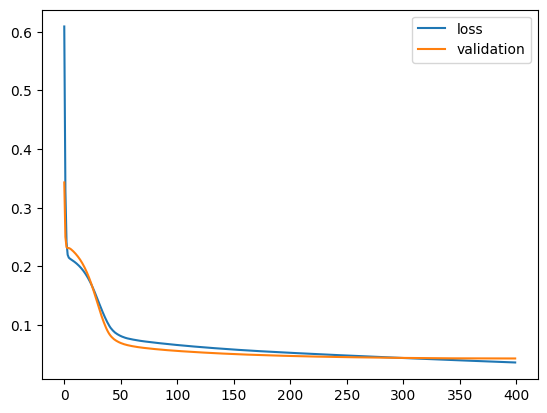

In [ ]:
from sklearn.metrics import mean_squared_error
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train = y_train.to_numpy().reshape(-1,1)
y_test = y_test.to_numpy().reshape(-1,1)

epocs = 400
learn_rate = .003
batch_size = 30
val_split = .4
verbose = 0

layer_structure = [X_train.shape[1],5,3,1]
for i in range(5):
  nn = Neural(layer_structure, epocs, learn_rate, batch_size, val_split, verbose)

  nn.fit(X_train, y_train)
  y_pred = nn.predict(X_test)
  print("Test error: ",mean_squared_error(y_test, y_pred))


nn.plot_learning()

**Configuration #5**

Test error:  0.031403554270673935
Test error:  0.02864429828323426
Test error:  0.03280493557965237
Test error:  0.03183786211520517
Test error:  0.05792094630099786


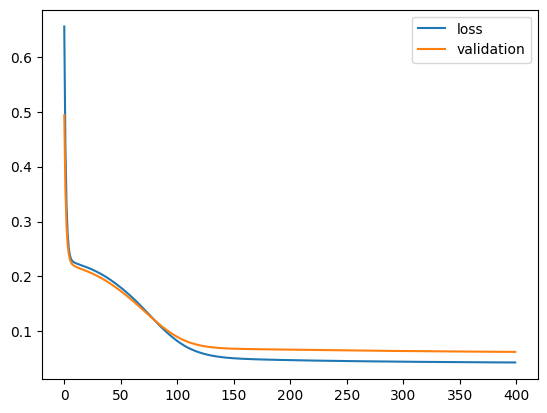

In [ ]:
from sklearn.metrics import mean_squared_error
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train = y_train.to_numpy().reshape(-1,1)
y_test = y_test.to_numpy().reshape(-1,1)

epocs = 400
learn_rate = .001
batch_size = 30
val_split = .3
verbose = 0

layer_structure = [X_train.shape[1],2,5,1]
for i in range(5):
  nn = Neural(layer_structure, epocs, learn_rate, batch_size, val_split, verbose)

  nn.fit(X_train, y_train)
  y_pred = nn.predict(X_test)
  print("Test error: ",mean_squared_error(y_test, y_pred))


nn.plot_learning()

**Configuration #6**

Test error:  0.030488184152179455
Test error:  0.05967876391512481
Test error:  0.02848916428645605
Test error:  0.03588592784117487
Test error:  0.02824277278333058


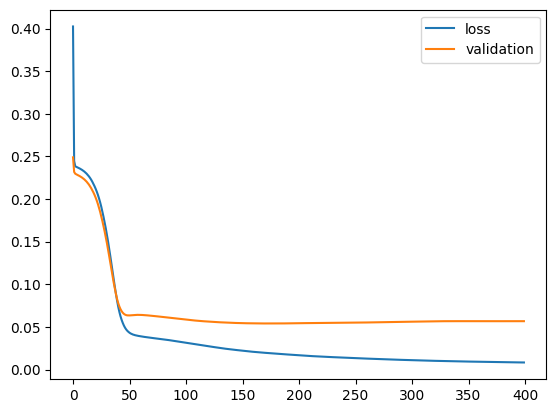

In [ ]:
from sklearn.metrics import mean_squared_error
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train = y_train.to_numpy().reshape(-1,1)
y_test = y_test.to_numpy().reshape(-1,1)

epocs = 400
learn_rate = .003
batch_size = 35
val_split = .3
verbose = 0

layer_structure = [X_train.shape[1],2,5,1]
for i in range(5):
  nn = Neural(layer_structure, epocs, learn_rate, batch_size, val_split, verbose)

  nn.fit(X_train, y_train)
  y_pred = nn.predict(X_test)
  print("Test error: ",mean_squared_error(y_test, y_pred))


nn.plot_learning()

**Configuration 7**

Test error:  0.039605612220943276
Test error:  0.03743727520218629
Test error:  0.03668249683372989
Test error:  0.0615688263777119
Test error:  0.0464418600057631


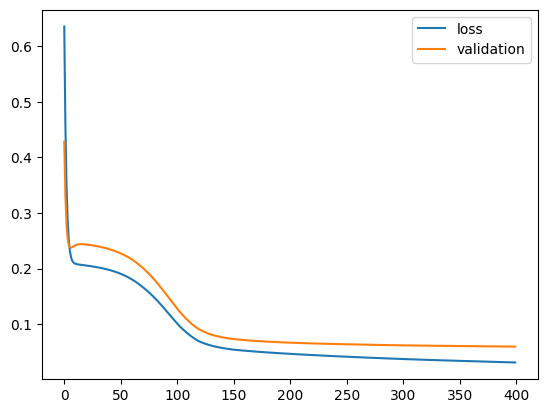

In [ ]:
from sklearn.metrics import mean_squared_error
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train = y_train.to_numpy().reshape(-1,1)
y_test = y_test.to_numpy().reshape(-1,1)

epocs = 400
learn_rate = .001
batch_size = 35
val_split = .2
verbose = 0

layer_structure = [X_train.shape[1],4,4,1]
for i in range(5):
  nn = Neural(layer_structure, epocs, learn_rate, batch_size, val_split, verbose)

  nn.fit(X_train, y_train)
  y_pred = nn.predict(X_test)
  print("Test error: ",mean_squared_error(y_test, y_pred))


nn.plot_learning()

**Configuration #8**

Test error:  0.06141781065570948
Test error:  0.030956468497438355
Test error:  0.033908472561088296
Test error:  0.03307277338798416
Test error:  0.03335675313504324


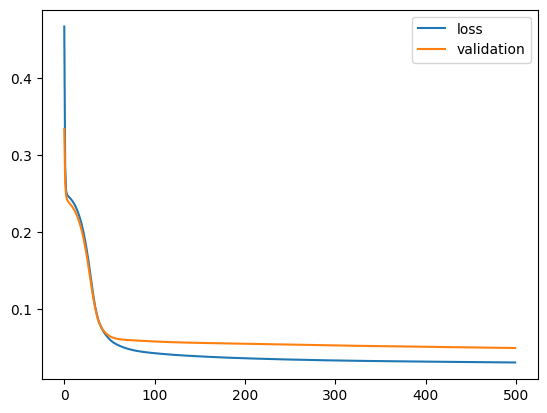

In [ ]:
from sklearn.metrics import mean_squared_error
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train = y_train.to_numpy().reshape(-1,1)
y_test = y_test.to_numpy().reshape(-1,1)

epocs = 500
learn_rate = .003
batch_size = 35
val_split = .5
verbose = 0

layer_structure = [X_train.shape[1],4,3,1]
for i in range(5):
  nn = Neural(layer_structure, epocs, learn_rate, batch_size, val_split, verbose)

  nn.fit(X_train, y_train)
  y_pred = nn.predict(X_test)
  print("Test error: ",mean_squared_error(y_test, y_pred))


nn.plot_learning()

**Configuration #9**

Test error:  0.03934534853540288
Test error:  0.06240571152652513
Test error:  0.03914986326183487
Test error:  0.06018812114973484
Test error:  0.038597804227536094


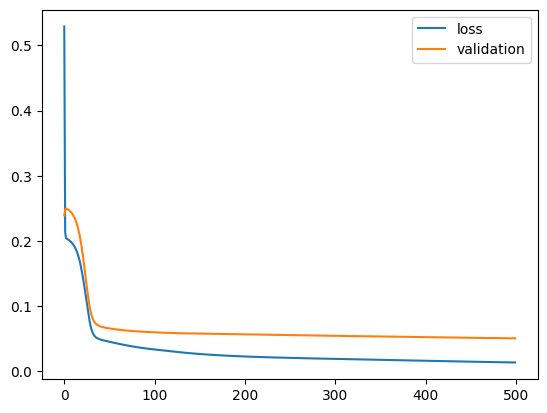

In [ ]:
from sklearn.metrics import mean_squared_error
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train = y_train.to_numpy().reshape(-1,1)
y_test = y_test.to_numpy().reshape(-1,1)

epocs = 500
learn_rate = .003
batch_size = 40
val_split = .2
verbose = 0

layer_structure = [X_train.shape[1],4,5,1]
for i in range(5):
  nn = Neural(layer_structure, epocs, learn_rate, batch_size, val_split, verbose)

  nn.fit(X_train, y_train)
  y_pred = nn.predict(X_test)
  print("Test error: ",mean_squared_error(y_test, y_pred))


nn.plot_learning()

**Configuration #10**

Test error:  0.04293448269620065
Test error:  0.06235460812569654
Test error:  0.040065776207820314
Test error:  0.04110694172604957
Test error:  0.061711412620882956


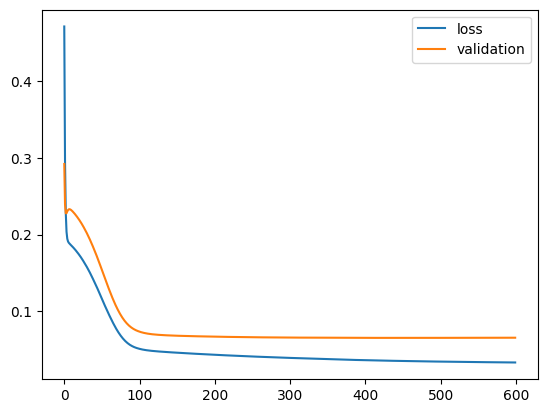

In [ ]:
from sklearn.metrics import mean_squared_error
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train = y_train.to_numpy().reshape(-1,1)
y_test = y_test.to_numpy().reshape(-1,1)

epocs = 600
learn_rate = .001
batch_size = 40
val_split = .2
verbose = 0

layer_structure = [X_train.shape[1],5,5,1]
for i in range(5):
  nn = Neural(layer_structure, epocs, learn_rate, batch_size, val_split, verbose)

  nn.fit(X_train, y_train)
  y_pred = nn.predict(X_test)
  print("Test error: ",mean_squared_error(y_test, y_pred))


nn.plot_learning()